In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        #rotation_range=20,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        brightness_range=[0.3,1.0],
        validation_split=0.1
)

batch_size = 64
shape = (224, 224)

base_dir = "/home/otiose/repos/epita/majurca/"

data_dir = base_dir + "top"

train_generator = train_datagen.flow_from_directory(
        directory=data_dir,
        target_size=shape,
        batch_size=batch_size,
        subset="training",
        class_mode="categorical")

validation_generator = train_datagen.flow_from_directory(
        directory=data_dir,
        target_size=shape,
        batch_size=batch_size,
        subset="validation",
        class_mode="categorical",
        shuffle=False
    )

Found 6814 images belonging to 7 classes.
Found 754 images belonging to 7 classes.


In [3]:
from sklearn.utils import class_weight
import numpy as np

class_weights_arr = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes), 
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights_arr))

In [4]:
inputShape = (shape+(3,))
outputShape = 7

In [5]:
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, EfficientNetB0, Xception
from tensorflow.keras.layers import (
    Flatten, 
    Dense,
    GlobalAveragePooling2D, 
    Dropout
)
from tensorflow.keras.models import Model, Sequential

base_model = VGG16(input_shape=inputShape, weights="imagenet", include_top=False)

x = base_model.get_layer('block5_conv3').output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(outputShape, activation='softmax')(x)

#base_model = InceptionV3(input_shape=inputShape, weights="imagenet", include_top=False)

#x = base_model.output
#x = Flatten()(x)
#x = Dense(1024, activation='relu')(x)
#x = Dropout(0.2)(x)
#x = Dense(outputShape, activation='softmax')(x)

#base_model = ResNet50(weights="imagenet", include_top=False, pooling="max")

#x = base_model.output
#x = Dense(outputShape, activation='softmax')(x)

#base_model = EfficientNetB0(input_shape=inputShape, weights="imagenet", include_top=False)

#x = base_model.output
#x = Flatten()(x)
#x = Dense(1024, activation="relu")(x)
#x = Dropout(0.5)(x)
#x = Dense(outputShape, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=x)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import clone_model

for layer in base_model.layers:
    layer.trainable = False

#optimizer = SGD(lr=0.2, momentum=0.9, decay=0.01)
optimizer = Adam()

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    class_weight=class_weights,
    epochs=10
)

Epoch 1/10
107/107 [==============================] - 52s 428ms/step - loss: 1.8715 - accuracy: 0.2018 - val_loss: 2.0081 - val_accuracy: 0.1353
Epoch 2/10
107/107 [==============================] - 41s 381ms/step - loss: 1.6435 - accuracy: 0.3139 - val_loss: 1.8029 - val_accuracy: 0.2546
Epoch 3/10
107/107 [==============================] - 42s 395ms/step - loss: 1.4625 - accuracy: 0.3923 - val_loss: 1.8905 - val_accuracy: 0.2109
Epoch 4/10
107/107 [==============================] - 41s 387ms/step - loss: 1.3666 - accuracy: 0.4347 - val_loss: 2.2711 - val_accuracy: 0.2135
Epoch 5/10
107/107 [==============================] - 41s 386ms/step - loss: 1.2816 - accuracy: 0.4723 - val_loss: 1.9466 - val_accuracy: 0.2082
Epoch 6/10
107/107 [==============================] - 39s 367ms/step - loss: 1.2042 - accuracy: 0.4985 - val_loss: 1.9752 - val_accuracy: 0.2122
Epoch 7/10
107/107 [==============================] - 39s 364ms/step - loss: 1.1816 - accuracy: 0.5082 - val_loss: 1.7111 - val_ac

In [8]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = Adam(learning_rate=1e-5)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
#from tensorflow.keras.models import load_model

#model = load_model(base_dir + "model/model-02/model.h5")

In [10]:
history = model.fit(
    x=train_generator,
    validation_data=validation_generator,
    class_weight=class_weights,
    epochs=300
)

Epoch 1/300
107/107 [==============================] - 55s 482ms/step - loss: 0.8204 - accuracy: 0.6644 - val_loss: 1.5468 - val_accuracy: 0.4284
Epoch 2/300
107/107 [==============================] - 50s 465ms/step - loss: 0.5779 - accuracy: 0.7772 - val_loss: 1.6157 - val_accuracy: 0.5066
Epoch 3/300
107/107 [==============================] - 50s 468ms/step - loss: 0.4607 - accuracy: 0.8311 - val_loss: 1.3093 - val_accuracy: 0.5703
Epoch 4/300
107/107 [==============================] - 50s 466ms/step - loss: 0.3862 - accuracy: 0.8607 - val_loss: 0.8616 - val_accuracy: 0.6923
Epoch 5/300
107/107 [==============================] - 50s 469ms/step - loss: 0.3173 - accuracy: 0.8848 - val_loss: 0.9454 - val_accuracy: 0.6883
Epoch 6/300
107/107 [==============================] - 51s 470ms/step - loss: 0.2621 - accuracy: 0.9071 - val_loss: 0.9393 - val_accuracy: 0.6830
Epoch 7/300
107/107 [==============================] - 51s 472ms/step - loss: 0.2373 - accuracy: 0.9159 - val_loss: 0.7531 -

In [11]:
import pandas as pd
from tensorflow.keras.models import save_model

model_dir = base_dir + "model/"

dirlist = os.listdir(model_dir)
dirlist.sort()

if len(dirlist) == 0:
    iteration = "01"
else:
    last_iteration = int(dirlist[-1].split("-")[1])
    iteration = "{:02d}".format(last_iteration + 1)

save_dir = model_dir + "model-" + iteration + "/"
os.mkdir(save_dir)

save_model(model, save_dir + "model.h5", save_format="h5")
hist_df = pd.DataFrame(history.history) 
hist_csv_file = save_dir + "history.csv"

with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_prob = model.predict(validation_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = validation_generator.classes

In [13]:
from glob import glob

target_names = [os.path.basename(path) for path in glob(data_dir + "/*")]

print(classification_report(y_true, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

                 pp       0.89      0.94      0.91        50
pet-barquette-clair       0.76      0.93      0.84        30
          pet-fonce       0.96      0.90      0.93       314
         pet-opaque       0.96      0.95      0.96       152
         pet-colore       1.00      0.94      0.97       100
          pet-clair       0.96      0.77      0.85        30
       pe-hd-opaque       0.73      0.94      0.82        78

           accuracy                           0.92       754
          macro avg       0.89      0.91      0.90       754
       weighted avg       0.93      0.92      0.92       754



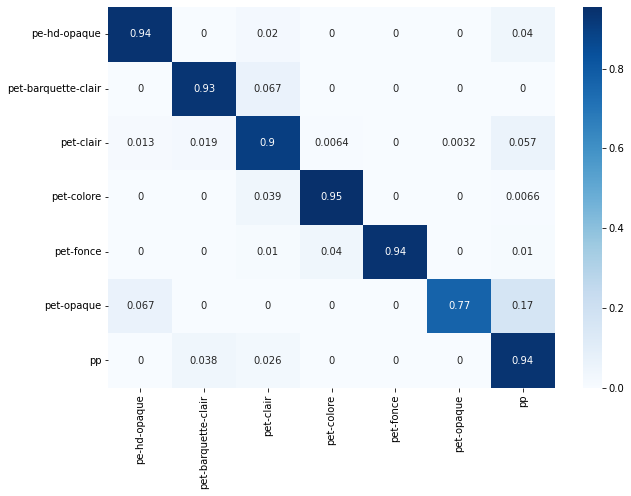

In [14]:
import seaborn as sn
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

labels = train_generator.class_indices.keys()
cm = confusion_matrix(y_true, y_pred, normalize="true")

df_cm = pd.DataFrame(cm, index = labels, columns = labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap=plt.cm.Blues)
plt.show()